# LangChain + Agent
**2024 삼성전자 무선사업부 생성형 AI 교육**

1. 기본 패키지 설정
2. Tool 설정
3. Agent + LLM 연결

In [1]:
# 1. 패키지 설치

%pip install google-search-results
%pip install wikipedia
%pip install langchain_experimental

  Preparing metadata (setup.py) ... - done
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32010 sha256=1193d676defa8172a92f9381e7bab4ba6015ae51cfa6fc7f49d7f0c004bbdc6c
  Stored in directory: /home/azureuser/.cache/pip/wheels/d3/b2/c3/03302d12bb44a2cdff3c9371f31b72c0c4e84b8d2285eeac53
Successfully built google-search-results
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... - done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=f821ab656404a922035c93f9628a7fe89fbaf4056965fd6f691354d334b647a0
  Stored in directory: /home/azureuser/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 kB 4.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use u

In [1]:
# 2. 기본 패키지 설정 & AzureOpenAI 환경설정

import os

from config_azure import (
    AZURE_OPENAI_API_VERSION,
    AZURE_OPENAI_ENDPOINT,
    AZURE_OPENAI_KEY,
    SERPAPI_API_KEY # google search
)
# lagchain 사용시 반드시 환경변수 값 사용!!
os.environ["OPENAI_API_TYPE"] = "azure"
os.environ["AZURE_OPENAI_API_KEY"] = AZURE_OPENAI_KEY
os.environ["AZURE_OPENAI_ENDPOINT"] = AZURE_OPENAI_ENDPOINT
os.environ["OPENAI_API_VERSION"] = AZURE_OPENAI_API_VERSION

os.environ["SERPAPI_API_KEY"] = SERPAPI_API_KEY

In [2]:
# 2. Azure OpenAI LLM

from langchain_openai import AzureOpenAI

completion_llm = AzureOpenAI(
    deployment_name="gpt-35-turbo-instruct",
    max_tokens=512,
    temperature=0.1,
)


from langchain_openai import AzureChatOpenAI

chat_llm = AzureChatOpenAI(
    deployment_name="gpt-35-turbo",
    max_tokens=512,
    temperature=0.2,
)

In [9]:
# 3-1. Agent 생성 without LCEL

from langchain.utilities import SerpAPIWrapper
from langchain.agents import AgentExecutor
from langchain.agents import create_react_agent
from langchain.agents import load_tools
from langchain_core.prompts import PromptTemplate

tools_name = ["serpapi", "wikipedia"] # google : 최신 사건, 제품, wikipedia : 역사적인 인물, 사건, 회사, 유명한 물품
tools = load_tools(tools_name)

template = """Answer the following questions as best you can. 
You have access to the following tools: {tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}
"""

prompt = PromptTemplate.from_template(template)

search_agent = create_react_agent(completion_llm, tools, prompt)

agent_executor = AgentExecutor(
    agent=search_agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
)


In [10]:
# 3-2. Agent 실행

query1 = "갤럭시 최신 핸드폰 기종 뭐야?"
query2 = "What is the latest Galaxy phone model?"
query3 = "구글 최신 생성형 인공지능 모델을 알려줘"
query4 = "Please tell me about Google’s latest generative artificial intelligence model."

agent_executor.invoke({"input": query1})



> Entering new AgentExecutor chain...
You should always think about what to do
Action: Search
Action Input: "Galaxy latest phone model"[{'position': 1, 'block_position': 'top', 'title': 'Samsung Galaxy S24 Ultra 512GB in Titanium Black (with 36 monthly installment payments + plan)', 'price': '$0.00 now', 'extracted_price': 0.0, 'link': 'https://www.verizon.com/business/products/devices/smartphones/samsung-galaxy-s24-ultra/', 'source': 'Verizon Business', 'thumbnail': 'https://serpapi.com/searches/667a7b017690dcfea369a627/images/d1ac8d9dc063389df12d85b20fd5b57a98e0db83050117b701d7a5d4049f1a43.webp', 'extensions': ['30-day returns (most)', 'Free by 6/27', 'Quality camera', 'Performs well', 'Long battery life', 'Quality display']}, {'position': 2, 'block_position': 'top', 'title': 'Samsung Galaxy S24 Ultra 512GB in Titanium Yellow (with 36 monthly installment payments + plan)', 'price': '$0.00 now', 'extracted_price': 0.0, 'link': 'https://www.verizon.com/business/products/devices/smart

{'input': '갤럭시 최신 핸드폰 기종 뭐야?',
 'output': 'The latest Galaxy phone model is the Samsung Galaxy S24 Ultra or the Samsung Galaxy S24 Plus.'}

In [11]:
# 4-1. Agent with LCEL

from langchain.tools.render import render_text_description
from langchain.agents.format_scratchpad import format_log_to_str
from langchain.agents.output_parsers import ReActSingleInputOutputParser

prompt = prompt.partial(
    tools=render_text_description(tools),
    tool_names=", ".join([t.name for t in tools]),
)
llm_with_stop = completion_llm.bind(stop=["\nObservation"])

agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_log_to_str(x["intermediate_steps"]),
    }
    | prompt
    | llm_with_stop
    | ReActSingleInputOutputParser()
)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)


In [12]:
# 4-2. 질문

query1 = "갤럭시 최신 핸드폰 기종 뭐야?"
query2 = "What is the latest Galaxy phone model?"
query3 = "구글 최신 생성형 인공지능 모델을 알려줘"
query4 = "Please tell me about Google’s latest generative artificial intelligence model."

agent_executor.invoke({"input": query1})



> Entering new AgentExecutor chain...
You should always think about what to do
Action: Search
Action Input: "latest Samsung phone model"['Discover Galaxy smartphones · Galaxy S24 Series · Galaxy Z Flip5 · Galaxy Z Fold5 · Galaxy S23 FE · Certified Re-Newed · Galaxy A Series.', 'Discover the best mobiles in Jordan. Explore new Samsung mobiles prices & models. Shop now from our various models for unbeatable prices at Samsung Jordan!', 'Get the latest information on the new Samsung Galaxy S24 Series, and other phone releases like Z Flip5, and Z Fold5.', 'Samsung Galaxy S24 Plus, $999, 6.7 inches ; Samsung Galaxy Z Fold 5, $1,799, 7.6 inches and 6.2 inches ; Samsung Galaxy Z Flip 5, $999, 6.7 inches ...', 'Best Overall: Samsung Galaxy S24 Ultra ; Best Budget Galaxy: Samsung Galaxy A25 5G ; Best Midrange Galaxy: Samsung Galaxy A35 5G ; Best Galaxy ...', 'Discover the full range of Samsung smartphones at Samsung Caribbean. Compare models by product type and features that matter to you.', '

{'input': '갤럭시 최신 핸드폰 기종 뭐야?',
 'output': 'The latest Samsung phone model is the Samsung Galaxy S24 series, which was released in January 2024. The Samsung Galaxy S24 is a high-end Android-based smartphone and part of the flagship Galaxy S series. Other recent models include the Samsung Galaxy Z Flip and the Samsung Galaxy Z Flip5. The Samsung Galaxy series also includes other devices such as tablets, laptops, and smartwatches.'}

### CSV 데이터 분석 Agent

In [13]:
# 파일 불러오기
import pandas as pd
df = pd.read_csv("titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
from langchain_experimental.agents.agent_toolkits.pandas.base import create_pandas_dataframe_agent

agent = create_pandas_dataframe_agent(completion_llm,
                                      df=df,
                                      allow_dangerous_code=True,
                                      verbose=True)

In [22]:
query = "전체 승객 중 1등급에 탑승한 20세 미만 여자의 생존율은 몇%야?"
agent.invoke(query)



> Entering new AgentExecutor chain...
Thought: We need to filter the dataframe to only include passengers who are 20 years old or younger, female, and in first class. Then we can calculate the survival rate.
Action: python_repl_ast
Action Input: df[(df['Age'] <= 20) & (df['Gender'] == 'female') & (df['Pclass'] == 1)]     PassengerId  Survived  Pclass  \
136          137         1       1   
291          292         1       1   
297          298         0       1   
307          308         1       1   
311          312         1       1   
329          330         1       1   
435          436         1       1   
504          505         1       1   
585          586         1       1   
689          690         1       1   
700          701         1       1   
781          782         1       1   
853          854         1       1   
887          888         1       1   

                                                  Name  Gender   Age  SibSp  \
136                       News

{'input': '전체 승객 중 1등급에 탑승한 20세 미만 여자의 생존율은 몇%야?',
 'output': 'The survival rate for female passengers under 20 years old in first class is 92.86%.'}



> Entering new AgentExecutor chain...
Thought: I need to use a graph to visualize the data and identify any outliers.
Action: python_repl_ast
Action Input: df.plot(kind='box')Axes(0.125,0.11;0.775x0.77)I can see that there are some outliers in the 'Age' and 'Fare' columns.
Action: python_repl_ast
Action Input: df[['Age', 'Fare']].plot(kind='box')Axes(0.125,0.11;0.775x0.77)I now know that the 'Age' and 'Fare' columns have outliers.
Final Answer: The 'Age' and 'Fare' columns have outliers.

> Finished chain.


{'input': '어떤 데이터에 이상치가 존재하는지 확인하기 위해 그래프 그려서 확인해줘',
 'output': "The 'Age' and 'Fare' columns have outliers."}

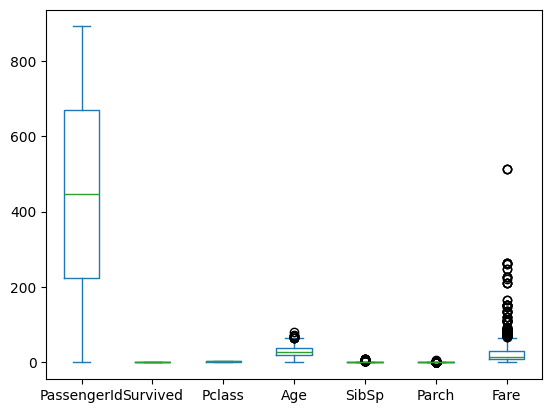

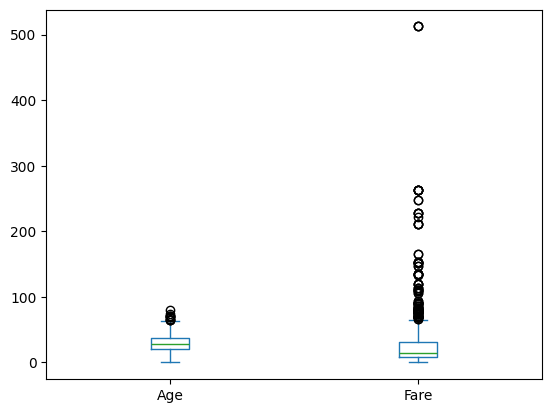

In [23]:
agent.invoke("어떤 데이터에 이상치가 존재하는지 확인하기 위해 그래프 그려서 확인해줘")



> Entering new AgentExecutor chain...
Thought: I need to group the data by passenger class and gender, and then plot a bar graph.
Action: python_repl_ast
Action Input: df.groupby(['Pclass', 'Gender'])['Survived'].mean().unstack().plot.bar(color=['orange', 'green'])Axes(0.125,0.11;0.775x0.77)I now know the final answer
Final Answer: The final answer is a bar graph showing the survival rate of passengers in each class and gender, with females represented in orange and males in green.

> Finished chain.


{'input': '\n1등급, 2등급, 3등급 선실등급에 탑승한 승객의 생존율을 세로 막대 그래프로 그려줘.\n각 등급별 남여 성별로 데이터를 나누고, 여성은 주황색/남성은 초록색으로 표시해줘\n',
 'output': 'The final answer is a bar graph showing the survival rate of passengers in each class and gender, with females represented in orange and males in green.'}

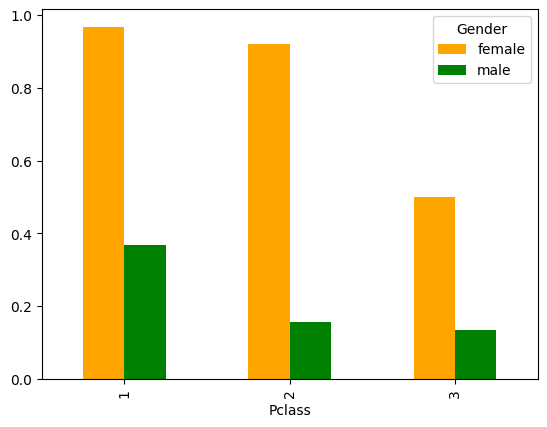

In [24]:
agent.invoke("""
1등급, 2등급, 3등급 선실등급에 탑승한 승객의 생존율을 세로 막대 그래프로 그려줘.
각 등급별 남여 성별로 데이터를 나누고, 여성은 주황색/남성은 초록색으로 표시해줘
""")